Main aim is to see how fast we can do matrix multiplication using different libraries.

In [1]:
import torch
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
A_arr = np.random.random(size=(100, 200))
B_arr = np.random.random(size=(200, 2))
A = A_arr.tolist()
B = B_arr.tolist()

## List implementation

In [3]:
%%timeit

n = len(A)
m = len(A[0])
k = len(B[0])
Y = []
for row in range(n):
    y = []
    for col in range(k):
        y.append(sum([A[row][i] * B[i][col] for i in range(m)]))
    Y.append(y)

5.14 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit

n = len(A)
m = len(A[0])
k = len(B[0])

Y = [[sum([A[row][i] * B[i][col] for i in range(m)]) for col in range(k)] for row in range(n)]

5.35 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
# assert np.allclose(np.array(Y), A_arr @ B_arr)

## Numpy

## Reimplementation

In [7]:
n, m = A_arr.shape
m, k = B_arr.shape

In [8]:
%%timeit

Y = np.zeros((n, k))
for row in range(n):
    y = np.zeros(k)
    for col in range(k):
        y[col] = sum([A_arr[row, i] * B_arr[i, col] for i in range(m)])
    Y[row] = y

28.1 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Lot of time is waisted in conversions from numpy to list on the way...

## Partial Broadcasting

In [9]:
%%timeit

Y = np.zeros((n, k))
for row in range(n):
    y = np.zeros(k)
    for col in range(k):
        y[col] = np.sum(A_arr[row] * B_arr[:, col])
    Y[row] = y

1.85 ms ± 55.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Full

Note, that nearly all time waist is in conversion!

In [10]:
%%timeit

C = np.array(A) @ np.array(B)

1.05 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit

C = A_arr @ B_arr

10.8 µs ± 69 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Let's look at conversion alone

In [19]:
%%timeit

np.array(A)
np.array(B)

1.02 ms ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# PyTorch

First without any GPU

In [13]:
A_tens = torch.tensor(A_arr)
B_tens = torch.tensor(B_arr)

In [14]:
%%timeit

A_tens @ B_tens

14.3 µs ± 844 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


And then with GPU

In [15]:
A_tens = torch.tensor(A_arr).cuda()
B_tens = torch.tensor(B_arr).cuda()

In [16]:
%%timeit

A_tens @ B_tens

46.2 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


What is going on here?

<AxesSubplot:xlabel='dim'>

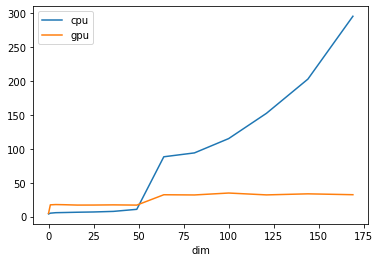

In [21]:
def run_test(dim, device, n=10_000):
    A = torch.rand(dim, dim, device=device)
    times = []
    for _ in range(n):
        start = datetime.now()
        A @ A
        times.append((datetime.now() - start).microseconds)
    return np.mean(times)

data = []
for dim in [n**2 for n in range(14)]:
    cpu = run_test(dim, 'cpu')
    gpu = run_test(dim, 'cuda')
    data.append([dim, cpu, gpu])

df = pd.DataFrame(data, columns=['dim', 'cpu', 'gpu']).set_index('dim')
df.plot()

Actually using GPU makes sense just from big matrixes. Not only that gpu really favours powers of two!

<AxesSubplot:xlabel='dim'>

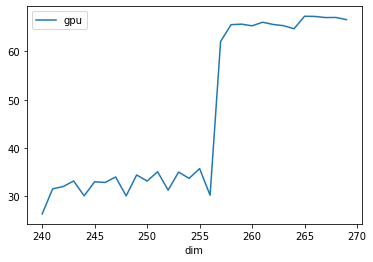

In [18]:
data = []
for dim in range(240, 270):
    gpu = run_test(dim, 'cuda')
    data.append([dim, gpu])

pd.DataFrame(data, columns=['dim', 'gpu']).set_index('dim').plot()

# Lessons learned

- Be super carefull with conversions from numpy/torch to list and vice-versa, they can be more costly than computation itself.
- Powers of two are important, when using GPU.